In [4]:
%load_ext autoreload
%autoreload 2

import sys  
sys.path.insert(0, 'functions')
sys.path.insert(0, 'training')

#from Clusterer import *
from plotting import *
from data_functions import *
import pandas as pd
import numpy as np
import compress_pickle as pickle  

time_TH=150
MIP=0.0006 ## GeV
MIP_TH=0.5 * MIP

/home/bishnu/miniconda3/envs/use_tensorflow/lib/python3.10/site-packages/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):
2023-05-15 14:36:59.240210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 14:36:59.768657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bishnu/Library/root/lib:/usr/local/lib:/usr/local/lib:/usr/local/cuda-11.8/lib64
2023-05-15 14:36:59.76871

## Path where the training model and prediction files are

In [5]:

take_log10 = False
path_to_result_dir='/media/miguel/Elements/Data_hcali/Data1/log10_Uniform_03-23/DeepSets_output'

In [6]:
## Number of block =1, num layers =8, latent size = 128 E,x, Y,Z + label "0" ECAL and "1" for HCAL 
#as input ECAL + HCAL 
block_with_label='results_hcal_ecal_with_label/Block_20230513_1315_concatTrue' 

## Number of block =1, num layers =4, latent size = 64 E,x, Y,Z as input ECAL + HCAL 
block_64_4='results_ecal_hcal_all/Block_20230511_2334_concatTrue' ## L4 and Size 64


## Number of block =1, num layers =8, latent size = 128 E,x, Y,Z as input ECAL + HCAL 
block_128_8='results_ecal_hcal_all_size128_L8/Block_20230512_0738_concatTrue'


## Number of block =2, num layers =8, latent size = 128 E,x, Y,Z as input ECAL + HCAL 
block_2_128_8='results_ecal_hcal_all_size128_L8_block2/Block_20230512_1147_concatTrue'


## Read mean and standard deviation for prediction
## Or convert normalized output back to orginal data structure
## Set block = some setting from above for now I am analyzing the training with label "0" and "1" assigned to ECAL and HCAL hits respectively

In [12]:
block = block_with_label

In [13]:
mean_std_data='preprocessed_data_ecal_hcal_all'
#mean_std_data='preprocessed_data_with_label'
means = pickle.load(open(f"{path_to_result_dir}/{mean_std_data}/test/means.p", 'rb'), compression='gzip')
stdvs = pickle.load(open(f"{path_to_result_dir}/{mean_std_data}/test/stdvs.p", 'rb'), compression='gzip')
means.keys()


npz_unpacked = np.load(path_to_result_dir + "/" + block + "/test_predictions.npz")

predictions = npz_unpacked['outputs']
targets = npz_unpacked['targets']


means.keys()
#Undo log: Exponentiate
#Averages and STdevs taken AFTER log10 taken. So undo scalar, then exp.
#scalar = (x-mean)/stdev
#undo_scalar = x'*stdev + mean

predictions = predictions*stdvs['genP'] + means['genP']
targets = targets*stdvs['genP'] + means['genP']

predictions = 10**predictions
targets = 10**targets


ClusterSum = predictions
GenP = targets

## Plot predicted (deep sets)  vs generated energy 

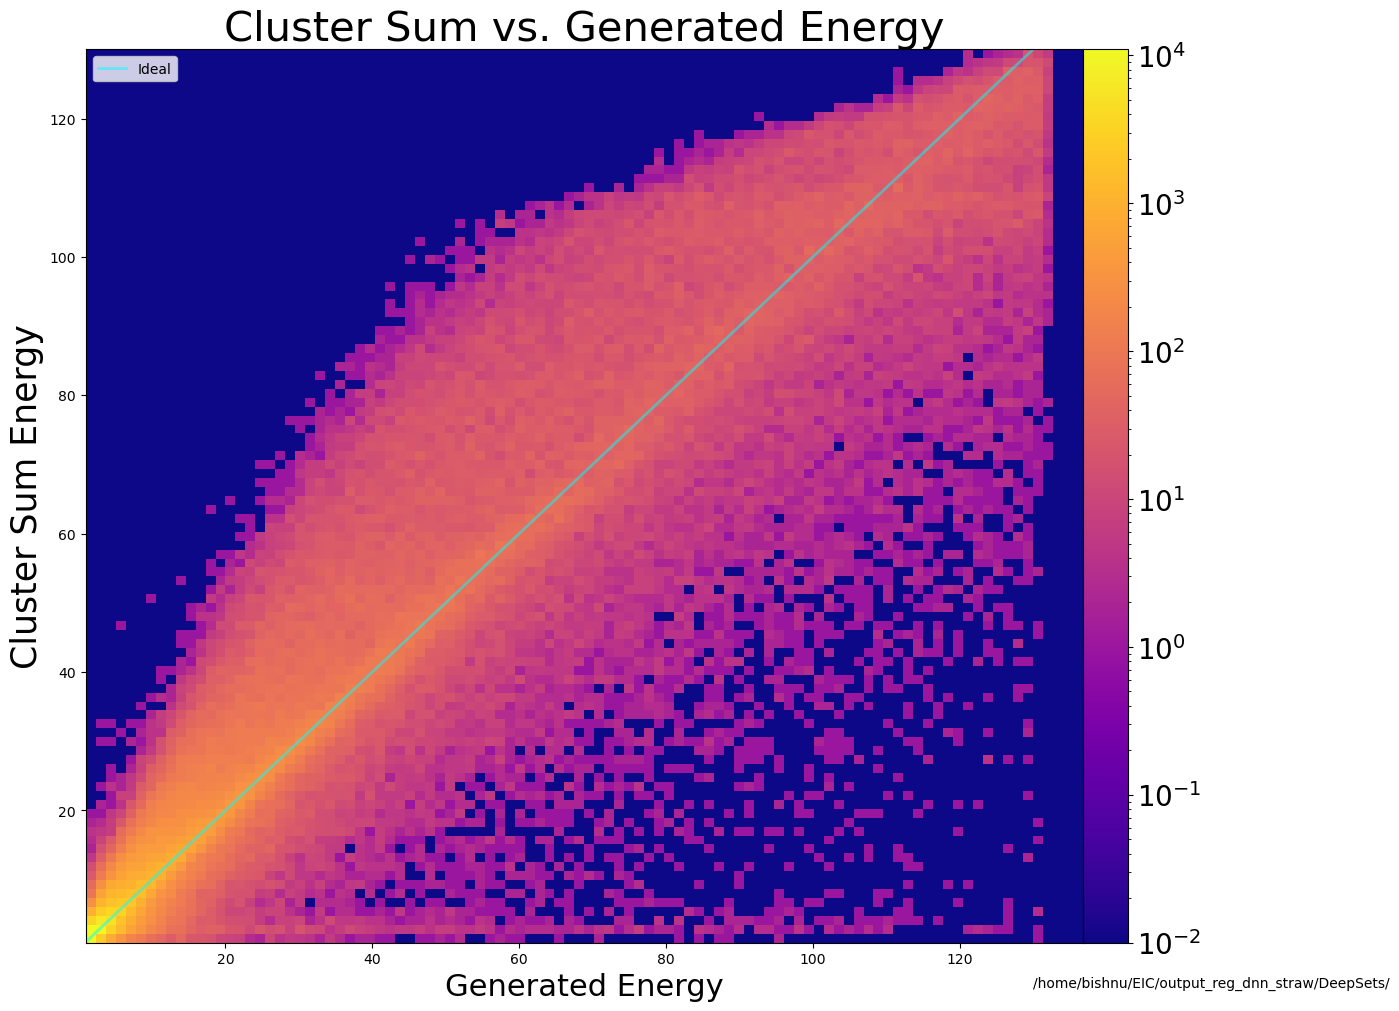

In [14]:
output_path='/home/bishnu/EIC/output_reg_dnn_straw/DeepSets/'
ClusterSum_vs_GenP(ClusterSum, GenP, output_path, take_log10)

## Compare the loss curves with different setting 


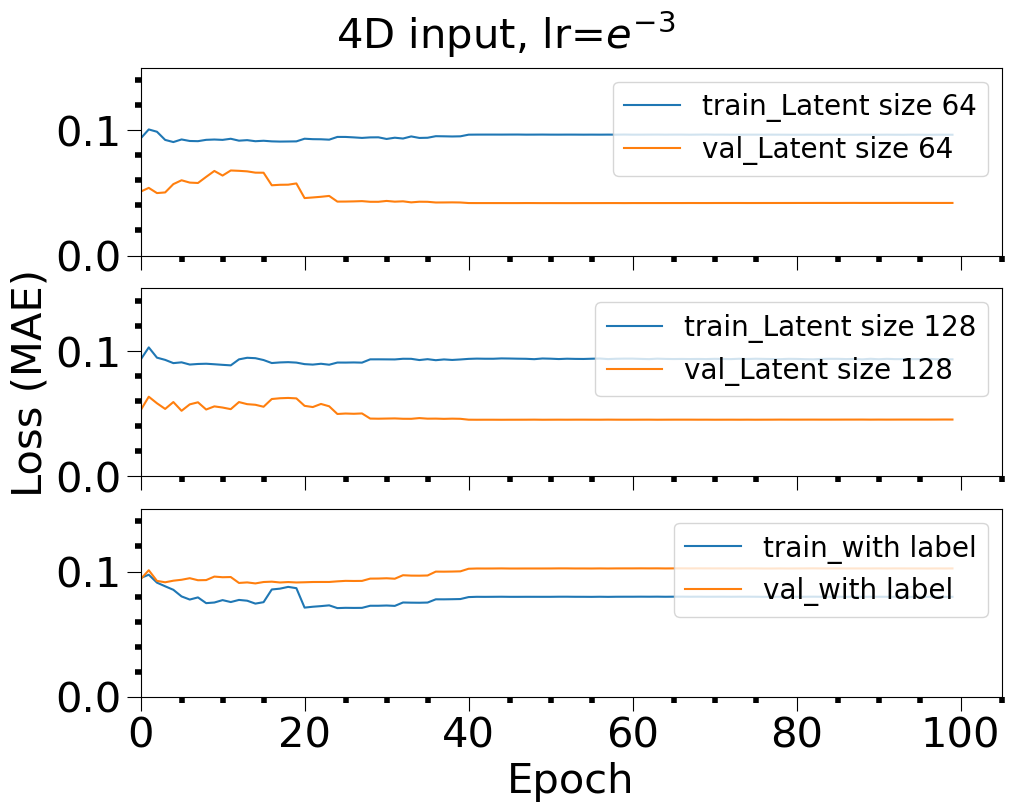

In [15]:
npz_unpacked_loss = np.load(path_to_result_dir  +'/'+ block + "/losses.npz")
loss = npz_unpacked_loss['training']
val_loss = npz_unpacked_loss['validation']

#Plot_Loss_Curve(loss[:,-1],val_loss[:,-1],output_path,loss_string="MSE") #label loss yourself here


result_paths=[path_to_result_dir  +'/'+ block_64_4, path_to_result_dir  +'/'+ block_128_8,  
              path_to_result_dir  +'/'+ block_with_label]#,
             #path_to_result_dir  +'/'+ block_2_128_8]


title="4D input, lr=$e^{-3}$"

legend_name=['Latent size 64', 'Latent size 128', 'with label']# '2 blocks'
xlim=[0, 105]
ylim=[0., 0.15]    
compare_loss_plots(result_paths, legend_name, title, 'pi+', xlim, ylim) 

## Deep set predicted Energy distribution

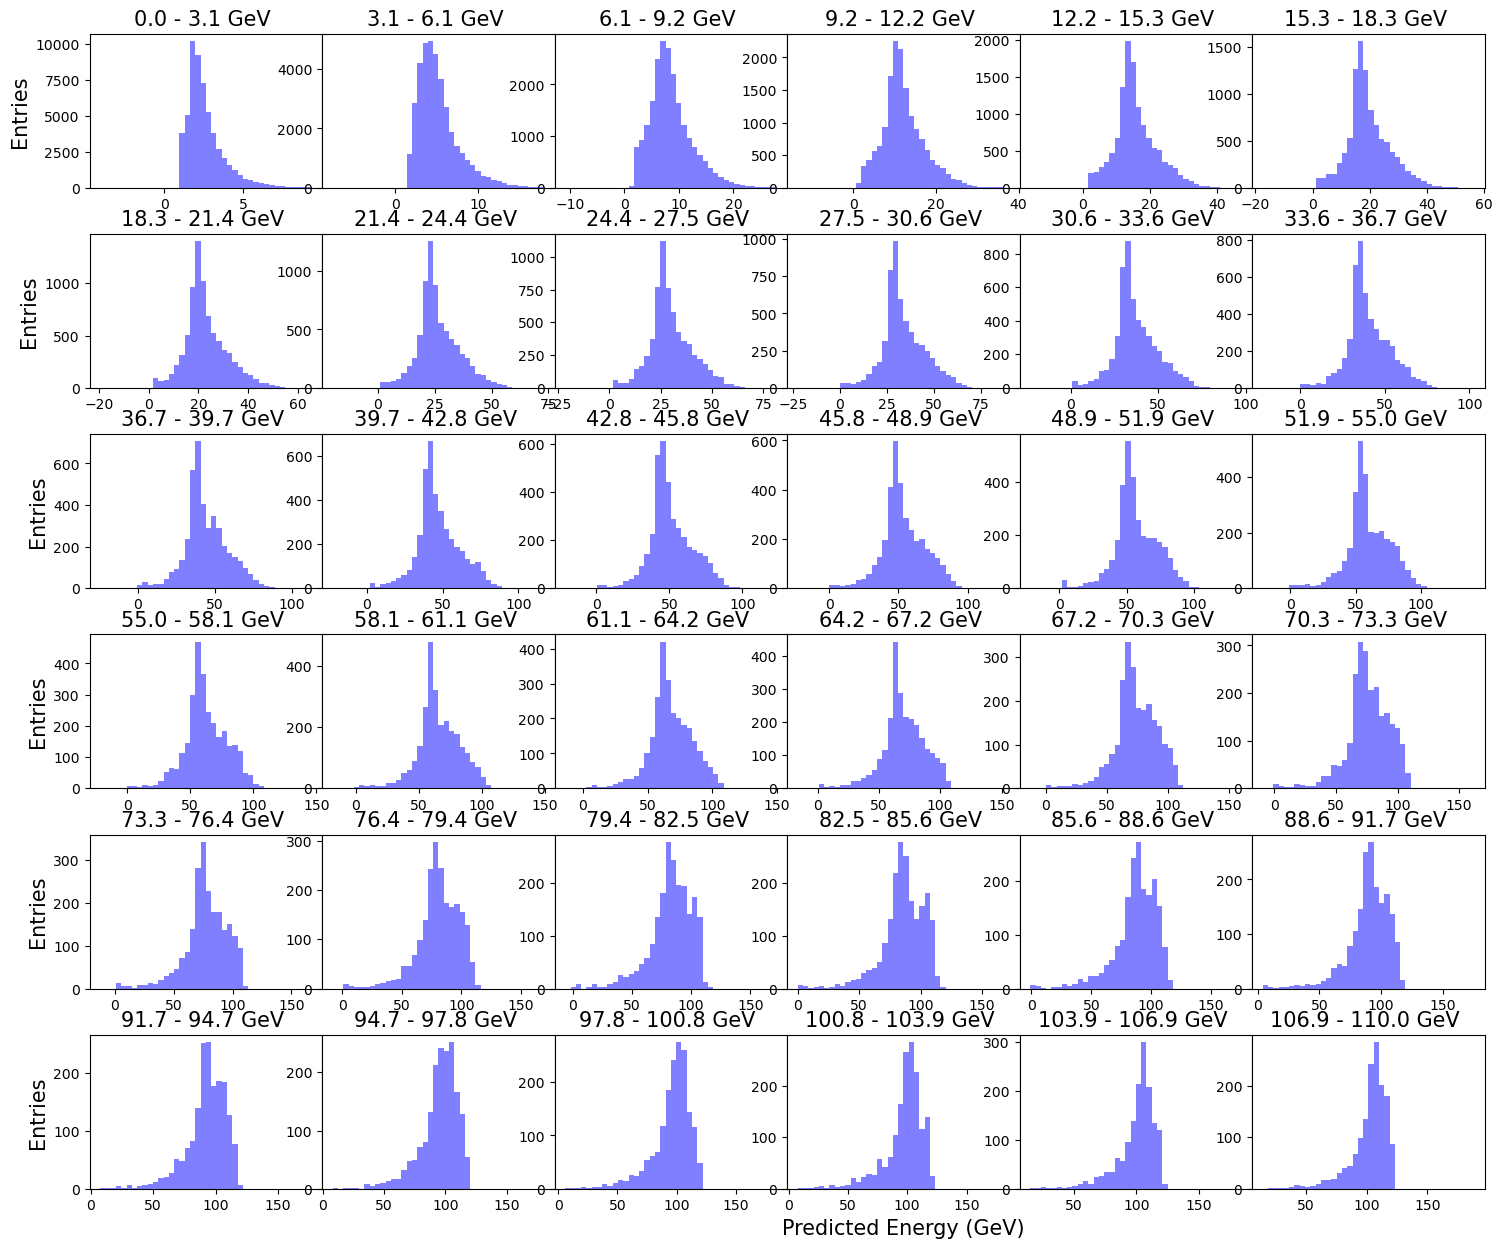

In [16]:
## Number of bins in given true energy bins
nbins=40

## Minimum and maximum value for the plots
min_val=0
max_val=110

## Numbers of segments we want to break the continuous generated true energy
Nbins=37
particle='pp'
data_type='continuous'

## CHOOSE A OPTION TO FIT OR NOT
fit_dist=False
binning=np.linspace(min_val, max_val, Nbins)
resolution_fit, pred_over_truth_fit, true_fit,slices_fit,resolution_scale_corr_median, median_scale_fit,slices_pred_truth,\
    res_std_median, res_sigma_median =get_res_scale_fit_log10_log2(GenP,ClusterSum, binning, nbins, data_type, particle,'energy', fit_dist)
                                                                   

## SAVE THE SLICES IN CSV FILE
## SAVE SLICES AND PREDICTION/TRUE

In [17]:
output_path='/home/bishnu/EIC/output_reg_dnn_straw/DeepSets/'
particle='pp'
detector='hcal'
particle_detector=f'{particle}_{detector}'
df = pd.DataFrame(slices_fit)
df.to_csv(f'{output_path}Ecal_hcal_pred_DeepSets_{particle_detector}.csv', index=False)  
#df_straw_truth = pd.DataFrame(slices_truth)
#df.to_csv(f'{output_path}/true_{approach}_{particle_detector}.csv', index=False)

## Pred over Truth
df_straw_truth = pd.DataFrame(slices_pred_truth)
df_straw_truth.to_csv(f'{output_path}Ecal_hcal_pred_true_DeepSets_{particle_detector}.csv', index=False)


## Strawman distribution on HCAL 

/home/bishnu/miniconda3/envs/use_tensorflow/lib/python3.10/site-packages/awkward0/array/base.py:622: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(where, (cls.numpy.ndarray, AwkwardArray)) and issubclass(where.dtype.type, (numpy.str, numpy.str_)):
/home/bishnu/miniconda3/envs/use_tensorflow/lib/python3.10/site-packages/awkward0/array/base.py:624: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif is

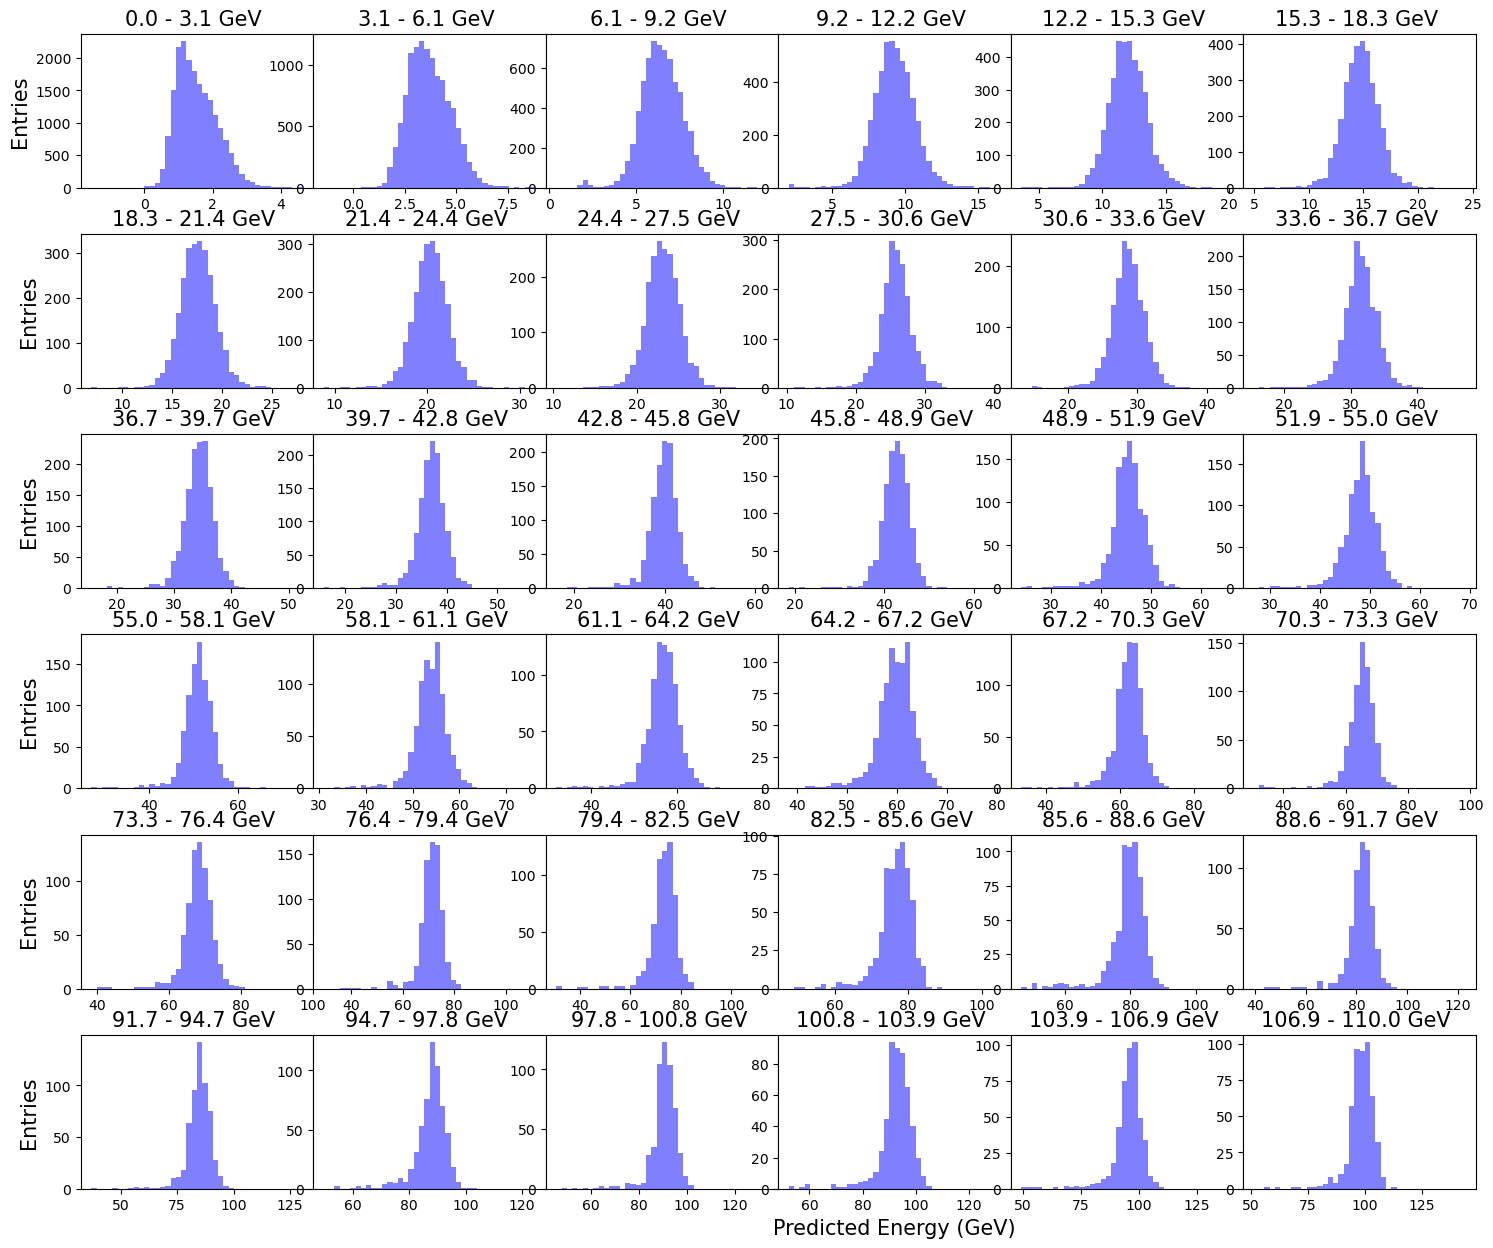

In [18]:
## ROOT FILE PATH FOR THE ECAL + HCAL DATA
path='/media/miguel/Elements/Data_hcali/Data1/log10_Uniform_03-23/log10_pi+_100_10k_17deg_ECAL_1/'

#log10_pi+_100_10k_2.83deg_ECAL_1/'
#path='/media/miguel/Elements/Data_hcali/Data1/log10_Uniform_03-23/log10_pi+_Uniform_0-140Gev_17deg_1/'

## NUMBER OF BINS IN EACH SLICES OF ENERGY
nbins=40

detector='hcal'
data_type='continuous'
particle='pi+'
min_val=0
max_val=110

## NUMBER OF ENERGY BINS YOU WANT TO DIVIDE FOR GENERATED CONTINUOUS TRUE ENERGY
Nbins=37


particle='pp'
data_type='continuous'

## OPTION TO FIT OR NOT TO FIT THE OUTPUT DISTRIBUTION
fit_dist=False
binning=np.linspace(min_val, max_val, Nbins)

## ARGUMENTS ARE PATH OF FILE 'path', analyze files between "0" to '10' or first 10 files
gen_energy,theta, hcal_sum, ecal_sum, total_sum =read_root_files_chain(path, detector, 0, 10,  det_Ecal=True)


## STRAWMAN reconstruction = ECAL/SF + HCAL/SF (SF is samping fraction)
resolution_fit, pred_over_truth_fit, true_fit,slices_fit,resolution_scale_corr_median, median_scale_fit,slices_pred_truth,\
    res_std_median, res_sigma_median =get_res_scale_fit_log10_log2(gen_energy, total_sum,  binning, nbins, data_type, 
                                                                   particle,'energy', fit_dist)

## Save the slices distribution of predicted energy into csv file for later use

In [19]:
particle_detector=f'{particle}_{detector}'
df = pd.DataFrame(slices_fit)
df.to_csv(f'{output_path}Ecal_hcal_pred_strawman_{particle_detector}.csv', index=False)  
#df_straw_truth = pd.DataFrame(slices_truth)
#df.to_csv(f'{output_path}/true_{approach}_{particle_detector}.csv', index=False)

## Pred over Truth
df_straw_truth = pd.DataFrame(slices_pred_truth)
df_straw_truth.to_csv(f'{output_path}Ecal_hcal_pred_true_strawman_{particle_detector}.csv', index=False)


## Compare the slices between Deep sets and strawman
## The distribution is (E_pred - E_true) / E_true

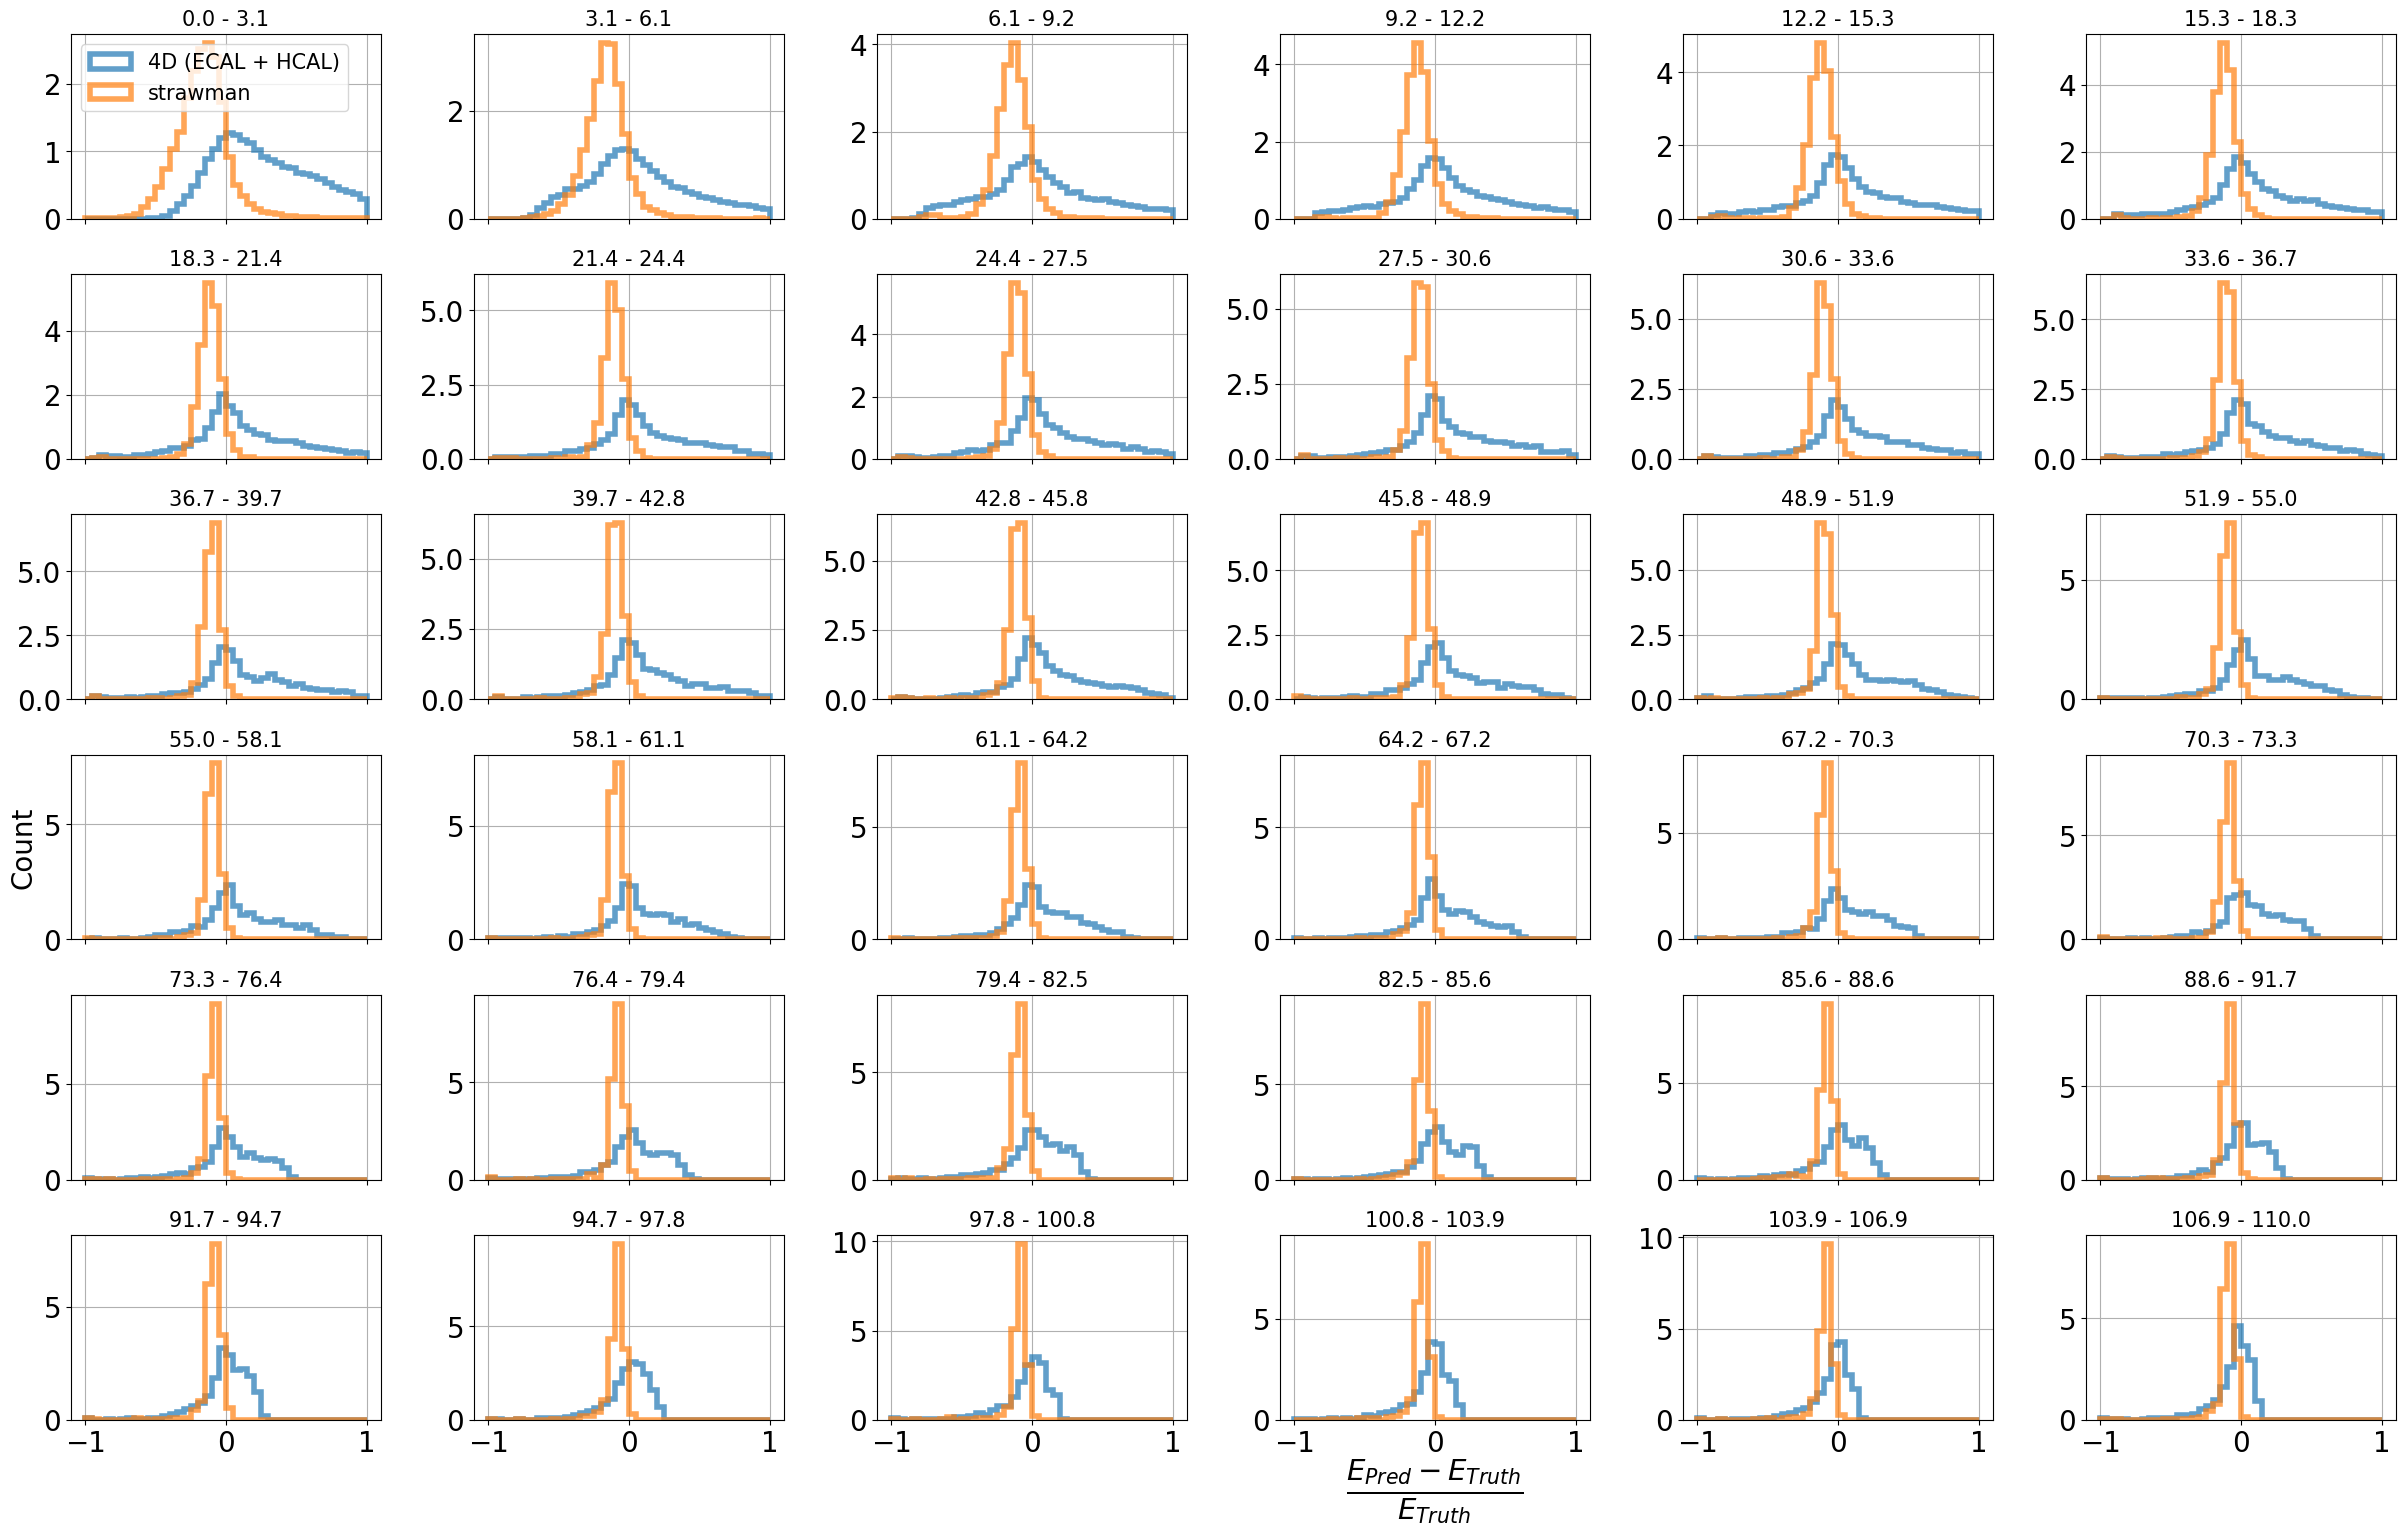

In [20]:
#output_path='/home/bishnu/EIC/output_reg_dnn_straw/DeepSets'
output_path='/home/bishnu/EIC/output_reg_dnn_straw/DeepSets/'

particle='pp'
detector='hcal'
approach=["DeepSets"]*4 #+ ['strawman']*1
labels=['4D (ECAL + HCAL)'  , 'strawman']#, '2D', '3D', '4D', 'strawman']      ## Input features
data_type='continuous'
files_pred_true=[f'{output_path}Ecal_hcal_pred_true_DeepSets_{particle}_{detector}.csv',
                f'{output_path}Ecal_hcal_pred_true_strawman_{particle}_{detector}.csv']
#Ecal_hcal_pred_true_DeepSets_{particle_detector}.csv

    
nbins=40
min_val=0
max_val=110
Nbins=37
binning=np.linspace(min_val, max_val, Nbins)


compare_energy_response_E_over_pred(files_pred_true, binning, data_type,particle,detector, 
                                    labels,ratio_E_pred=True, ylogscale=False)